acc: 65.413
f1: 0.547

## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop

In [2]:
train_dir = '/opt/ml/input/data/train'

## 2. Train Dataset 정의

In [3]:
class TrainDataset(Dataset):
    def __init__(self,img_paths,labels,trans_dict,val=False):
        self.img_paths = img_paths
        self.labels = labels
        self.trans_dict = trans_dict
        self.val = val
        
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index])
        label = self.labels[index]
        if self.trans_dict:
            if self.val:
                image = self.trans_dict['val'](image)
            elif label in [0,1,3,4]:
                image = self.trans_dict['train1'](image)
            else:
                image = self.trans_dict['train2'](image)
        
        return image,label

    def __len__(self):
        return len(self.img_paths)

## 3. DataLoader 정의

sample 이미지 살펴보고 transform 결정

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open(image_paths[47])
print(labels[47])
plt.imshow(image)

NameError: name 'image_paths' is not defined

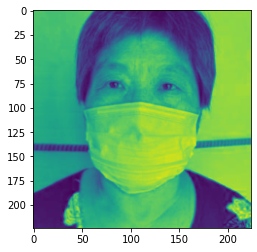

In [253]:
image2 = data_transform['train1'](image)
plt.imshow(image2[0])

In [7]:
#hyperparam 정의
num_epoch = 15
num_classes = 18
batch_size = 64
val_split = 0.2
random_seed= 48
shuffle_dataset = True

In [17]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_info = pd.read_csv(os.path.join(train_dir, 'train3.csv'))
image_paths = train_info['path']
labels = train_info['category']

#transform 정의
data_transform = {
    'train1': transforms.Compose([
                CenterCrop(300),  
                Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ]),
    'train2': transforms.Compose([
                    CenterCrop(300),  
                    Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.5)],p=0.5),
                    #transforms.RandomApply(transforms=[transforms.Pad(padding=5, fill=0, padding_mode='constant')],p=0.5),
                    transforms.RandomApply(transforms=[transforms.RandomPerspective(distortion_scale=0.2, p=0.5)],p=0.5),
                    ToTensor(),
                    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
                ]),
    'val': transforms.Compose([
                Resize((224, 224), Image.BILINEAR),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ])
}

#train val split
dataset_size = len(labels)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = TrainDataset(list(image_paths[train_indices]),list(labels[train_indices]),data_transform)
val_dataset = TrainDataset(list(image_paths[val_indices]),list(labels[val_indices]),data_transform,val=True)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    drop_last=True
)
print(len(train_dataset),len(val_dataset),dataset_size)

15120 3780 18900


## 4. Model 정의

In [14]:
from custom_models import ResnetModel as MyModel

## 5. Train

In [21]:
from sklearn.metrics import f1_score
import numpy as np
from loss import f1_loss

# 모델을 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=num_classes).to(device)


#loss function, optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

#모델 학습
from tqdm import tqdm
right_count = [0 for _ in range(num_classes)]
wrong_count = [0 for _ in range(num_classes)]

for epoch in tqdm(range(num_epoch)):
    #train
    model.train()
    cur_loss,cur_acc,cur_f1 = 0.0,0.0,0.0
    for i,data in enumerate(train_dataloader):
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        model_output = model(images)
        loss = criterion(model_output,labels)
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.item()
        
        predict = model_output.argmax(dim=-1)
        cur_acc += torch.sum(labels==predict)
        
        f1 = f1_loss(labels,model_output)
        cur_f1 += f1
                
        for k in range(batch_size):
            if predict[k]==labels[k]: right_count[labels[k]]+=1
            else: wrong_count[labels[k]]+=1
        
        if i%100==99:
            print('[%d,%5d] train_loss: %.3f, train_acc:%.3f, train_f1:%.3f'% (epoch+1,i+1,cur_loss/100,cur_acc/1600,cur_f1/100))
            cur_loss,cur_acc,cur_f1 = 0.0,0.0,0.0
        
    #eval
    model.eval()
    valid_loss,valid_acc,valid_f1=0.0,0.0,0.0
    for i,data in enumerate(val_dataloader):
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        
        model_output = model(images)
        #print(model_output,labels)
        loss = criterion(model_output,labels)
        valid_loss += loss.item()
        
        predict = model_output.argmax(dim=-1)
        valid_acc += torch.sum(labels==predict)
        
        f1 = f1_loss(labels,model_output)
        valid_f1 += f1
        
    print('epoch [%d] valid_loss: %.3f, valid_acc:%.3f, valid_f1:%.3f'% (epoch+1,valid_loss/(i+1),valid_acc/(4*(i+1)),valid_f1/(i+1)))

print('training finished')

  0%|          | 0/15 [00:00<?, ?it/s]

[1,  100] train_loss: 2.135, train_acc:0.354, train_f1:5.199
[1,  200] train_loss: 1.460, train_acc:0.555, train_f1:7.745
[1,  300] train_loss: 1.254, train_acc:0.621, train_f1:7.986
[1,  400] train_loss: 1.216, train_acc:0.636, train_f1:8.221
[1,  500] train_loss: 1.120, train_acc:0.662, train_f1:8.358
[1,  600] train_loss: 1.054, train_acc:0.671, train_f1:8.499
[1,  700] train_loss: 1.060, train_acc:0.664, train_f1:8.643
[1,  800] train_loss: 1.027, train_acc:0.681, train_f1:8.169
[1,  900] train_loss: 0.964, train_acc:0.699, train_f1:8.391


  7%|▋         | 1/15 [02:14<31:26, 134.74s/it]

epoch [1] valid_loss: 0.977, valid_acc:0.691, valid_f1:7.443
[2,  100] train_loss: 0.960, train_acc:0.698, train_f1:8.576
[2,  200] train_loss: 0.839, train_acc:0.744, train_f1:8.606
[2,  300] train_loss: 0.864, train_acc:0.716, train_f1:8.423
[2,  400] train_loss: 0.905, train_acc:0.714, train_f1:8.482
[2,  500] train_loss: 0.853, train_acc:0.736, train_f1:8.730
[2,  600] train_loss: 0.838, train_acc:0.730, train_f1:8.696
[2,  700] train_loss: 0.890, train_acc:0.716, train_f1:8.771
[2,  800] train_loss: 0.887, train_acc:0.709, train_f1:8.306
[2,  900] train_loss: 0.824, train_acc:0.724, train_f1:8.470


 13%|█▎        | 2/15 [04:38<29:47, 137.49s/it]

epoch [2] valid_loss: 0.876, valid_acc:0.716, valid_f1:7.559
[3,  100] train_loss: 0.842, train_acc:0.719, train_f1:8.693
[3,  200] train_loss: 0.764, train_acc:0.753, train_f1:8.661
[3,  300] train_loss: 0.758, train_acc:0.746, train_f1:8.492
[3,  400] train_loss: 0.823, train_acc:0.727, train_f1:8.532
[3,  500] train_loss: 0.787, train_acc:0.743, train_f1:8.747
[3,  600] train_loss: 0.784, train_acc:0.743, train_f1:8.780
[3,  700] train_loss: 0.818, train_acc:0.723, train_f1:8.755
[3,  800] train_loss: 0.824, train_acc:0.721, train_f1:8.349
[3,  900] train_loss: 0.757, train_acc:0.749, train_f1:8.607


 20%|██        | 3/15 [06:49<27:04, 135.37s/it]

epoch [3] valid_loss: 0.836, valid_acc:0.720, valid_f1:7.612
[4,  100] train_loss: 0.808, train_acc:0.736, train_f1:8.713
[4,  200] train_loss: 0.737, train_acc:0.757, train_f1:8.694
[4,  300] train_loss: 0.750, train_acc:0.741, train_f1:8.544
[4,  400] train_loss: 0.770, train_acc:0.738, train_f1:8.574
[4,  500] train_loss: 0.748, train_acc:0.751, train_f1:8.835
[4,  600] train_loss: 0.734, train_acc:0.764, train_f1:8.759
[4,  700] train_loss: 0.774, train_acc:0.734, train_f1:8.804
[4,  800] train_loss: 0.794, train_acc:0.747, train_f1:8.377
[4,  900] train_loss: 0.745, train_acc:0.757, train_f1:8.574


 27%|██▋       | 4/15 [08:59<24:32, 133.89s/it]

epoch [4] valid_loss: 0.819, valid_acc:0.723, valid_f1:7.565
[5,  100] train_loss: 0.757, train_acc:0.754, train_f1:8.810
[5,  200] train_loss: 0.675, train_acc:0.771, train_f1:8.689
[5,  300] train_loss: 0.705, train_acc:0.762, train_f1:8.605
[5,  400] train_loss: 0.781, train_acc:0.726, train_f1:8.566
[5,  500] train_loss: 0.754, train_acc:0.749, train_f1:8.752
[5,  600] train_loss: 0.724, train_acc:0.758, train_f1:8.784
[5,  700] train_loss: 0.755, train_acc:0.736, train_f1:8.815
[5,  800] train_loss: 0.769, train_acc:0.733, train_f1:8.362
[5,  900] train_loss: 0.723, train_acc:0.762, train_f1:8.573


 33%|███▎      | 5/15 [11:09<22:07, 132.78s/it]

epoch [5] valid_loss: 0.808, valid_acc:0.725, valid_f1:7.629
[6,  100] train_loss: 0.768, train_acc:0.736, train_f1:8.699
[6,  200] train_loss: 0.689, train_acc:0.771, train_f1:8.682
[6,  300] train_loss: 0.652, train_acc:0.771, train_f1:8.566
[6,  400] train_loss: 0.757, train_acc:0.744, train_f1:8.615
[6,  500] train_loss: 0.722, train_acc:0.758, train_f1:8.771
[6,  600] train_loss: 0.682, train_acc:0.780, train_f1:8.846
[6,  700] train_loss: 0.733, train_acc:0.738, train_f1:8.808
[6,  800] train_loss: 0.791, train_acc:0.736, train_f1:8.378
[6,  900] train_loss: 0.714, train_acc:0.754, train_f1:8.534


 40%|████      | 6/15 [13:36<20:33, 137.05s/it]

epoch [6] valid_loss: 0.804, valid_acc:0.725, valid_f1:7.674
[7,  100] train_loss: 0.722, train_acc:0.743, train_f1:8.754
[7,  200] train_loss: 0.673, train_acc:0.767, train_f1:8.711
[7,  300] train_loss: 0.680, train_acc:0.760, train_f1:8.659
[7,  400] train_loss: 0.720, train_acc:0.757, train_f1:8.602
[7,  500] train_loss: 0.688, train_acc:0.784, train_f1:8.822
[7,  600] train_loss: 0.686, train_acc:0.770, train_f1:8.847
[7,  700] train_loss: 0.724, train_acc:0.760, train_f1:8.793
[7,  800] train_loss: 0.756, train_acc:0.751, train_f1:8.375
[7,  900] train_loss: 0.695, train_acc:0.765, train_f1:8.611


 47%|████▋     | 7/15 [15:56<18:22, 137.77s/it]

epoch [7] valid_loss: 0.785, valid_acc:0.733, valid_f1:7.634
[8,  100] train_loss: 0.717, train_acc:0.751, train_f1:8.765
[8,  200] train_loss: 0.653, train_acc:0.783, train_f1:8.718
[8,  300] train_loss: 0.649, train_acc:0.774, train_f1:8.654
[8,  400] train_loss: 0.716, train_acc:0.752, train_f1:8.646
[8,  500] train_loss: 0.701, train_acc:0.762, train_f1:8.837
[8,  600] train_loss: 0.669, train_acc:0.779, train_f1:8.802
[8,  700] train_loss: 0.712, train_acc:0.753, train_f1:8.882
[8,  800] train_loss: 0.751, train_acc:0.737, train_f1:8.424
[8,  900] train_loss: 0.692, train_acc:0.781, train_f1:8.640


 53%|█████▎    | 8/15 [19:35<18:55, 162.15s/it]

epoch [8] valid_loss: 0.772, valid_acc:0.737, valid_f1:7.611
[9,  100] train_loss: 0.711, train_acc:0.762, train_f1:8.773
[9,  200] train_loss: 0.666, train_acc:0.774, train_f1:8.673
[9,  300] train_loss: 0.649, train_acc:0.773, train_f1:8.629
[9,  400] train_loss: 0.706, train_acc:0.762, train_f1:8.608
[9,  500] train_loss: 0.685, train_acc:0.773, train_f1:8.827
[9,  600] train_loss: 0.665, train_acc:0.771, train_f1:8.830
[9,  700] train_loss: 0.710, train_acc:0.759, train_f1:8.824
[9,  800] train_loss: 0.744, train_acc:0.752, train_f1:8.370
[9,  900] train_loss: 0.682, train_acc:0.770, train_f1:8.596


 60%|██████    | 9/15 [25:05<21:15, 212.52s/it]

epoch [9] valid_loss: 0.766, valid_acc:0.735, valid_f1:7.622
[10,  100] train_loss: 0.730, train_acc:0.762, train_f1:8.799
[10,  200] train_loss: 0.641, train_acc:0.787, train_f1:8.681
[10,  300] train_loss: 0.654, train_acc:0.778, train_f1:8.620
[10,  400] train_loss: 0.708, train_acc:0.767, train_f1:8.653
[10,  500] train_loss: 0.675, train_acc:0.770, train_f1:8.842
[10,  600] train_loss: 0.667, train_acc:0.772, train_f1:8.851
[10,  700] train_loss: 0.699, train_acc:0.764, train_f1:8.916
[10,  800] train_loss: 0.763, train_acc:0.741, train_f1:8.389
[10,  900] train_loss: 0.697, train_acc:0.770, train_f1:8.572


 67%|██████▋   | 10/15 [30:04<19:53, 238.64s/it]

epoch [10] valid_loss: 0.762, valid_acc:0.739, valid_f1:7.601
[11,  100] train_loss: 0.738, train_acc:0.737, train_f1:8.762
[11,  200] train_loss: 0.639, train_acc:0.779, train_f1:8.699
[11,  300] train_loss: 0.635, train_acc:0.781, train_f1:8.672
[11,  400] train_loss: 0.701, train_acc:0.754, train_f1:8.589
[11,  500] train_loss: 0.697, train_acc:0.768, train_f1:8.811
[11,  600] train_loss: 0.673, train_acc:0.772, train_f1:8.847
[11,  700] train_loss: 0.709, train_acc:0.744, train_f1:8.862
[11,  800] train_loss: 0.752, train_acc:0.736, train_f1:8.376
[11,  900] train_loss: 0.696, train_acc:0.757, train_f1:8.610


 73%|███████▎  | 11/15 [35:00<17:02, 255.61s/it]

epoch [11] valid_loss: 0.760, valid_acc:0.743, valid_f1:7.583
[12,  100] train_loss: 0.690, train_acc:0.777, train_f1:8.793
[12,  200] train_loss: 0.648, train_acc:0.778, train_f1:8.698
[12,  300] train_loss: 0.621, train_acc:0.787, train_f1:8.688
[12,  400] train_loss: 0.704, train_acc:0.753, train_f1:8.653
[12,  500] train_loss: 0.675, train_acc:0.773, train_f1:8.780
[12,  600] train_loss: 0.649, train_acc:0.781, train_f1:8.799
[12,  700] train_loss: 0.679, train_acc:0.770, train_f1:8.891
[12,  800] train_loss: 0.730, train_acc:0.752, train_f1:8.438
[12,  900] train_loss: 0.690, train_acc:0.762, train_f1:8.571


 80%|████████  | 12/15 [40:29<13:53, 277.87s/it]

epoch [12] valid_loss: 0.777, valid_acc:0.731, valid_f1:7.597
[13,  100] train_loss: 0.690, train_acc:0.768, train_f1:8.858
[13,  200] train_loss: 0.618, train_acc:0.782, train_f1:8.690
[13,  300] train_loss: 0.633, train_acc:0.769, train_f1:8.612
[13,  400] train_loss: 0.687, train_acc:0.767, train_f1:8.696
[13,  500] train_loss: 0.663, train_acc:0.778, train_f1:8.813
[13,  600] train_loss: 0.659, train_acc:0.776, train_f1:8.806
[13,  700] train_loss: 0.677, train_acc:0.768, train_f1:8.912
[13,  800] train_loss: 0.758, train_acc:0.743, train_f1:8.365
[13,  900] train_loss: 0.644, train_acc:0.781, train_f1:8.667


 87%|████████▋ | 13/15 [45:25<09:26, 283.12s/it]

epoch [13] valid_loss: 0.747, valid_acc:0.740, valid_f1:7.603
[14,  100] train_loss: 0.705, train_acc:0.755, train_f1:8.759
[14,  200] train_loss: 0.634, train_acc:0.781, train_f1:8.693
[14,  300] train_loss: 0.611, train_acc:0.776, train_f1:8.666
[14,  400] train_loss: 0.697, train_acc:0.760, train_f1:8.702
[14,  500] train_loss: 0.677, train_acc:0.767, train_f1:8.785
[14,  600] train_loss: 0.660, train_acc:0.786, train_f1:8.889
[14,  700] train_loss: 0.702, train_acc:0.758, train_f1:8.865
[14,  800] train_loss: 0.732, train_acc:0.750, train_f1:8.402
[14,  900] train_loss: 0.693, train_acc:0.766, train_f1:8.630


 93%|█████████▎| 14/15 [50:50<04:55, 295.83s/it]

epoch [14] valid_loss: 0.767, valid_acc:0.737, valid_f1:7.631
[15,  100] train_loss: 0.686, train_acc:0.756, train_f1:8.833
[15,  200] train_loss: 0.634, train_acc:0.777, train_f1:8.719
[15,  300] train_loss: 0.630, train_acc:0.782, train_f1:8.631
[15,  400] train_loss: 0.706, train_acc:0.766, train_f1:8.631
[15,  500] train_loss: 0.659, train_acc:0.772, train_f1:8.795
[15,  600] train_loss: 0.662, train_acc:0.781, train_f1:8.873
[15,  700] train_loss: 0.705, train_acc:0.766, train_f1:8.832
[15,  800] train_loss: 0.728, train_acc:0.737, train_f1:8.399
[15,  900] train_loss: 0.660, train_acc:0.770, train_f1:8.606


100%|██████████| 15/15 [55:53<00:00, 223.59s/it]

epoch [15] valid_loss: 0.764, valid_acc:0.738, valid_f1:7.628
training finished


In [22]:
torch.save(model,'models/0826_1_model.pth')

In [23]:
print(right_count)

[28106, 17411, 2119, 37281, 38850, 2946, 4273, 2461, 107, 5993, 5214, 233, 5452, 3567, 157, 7507, 7964, 232]


In [24]:
print(wrong_count)

[4969, 7354, 2951, 6864, 9660, 3654, 2267, 2489, 853, 2737, 4791, 982, 1073, 1428, 848, 1148, 1861, 998]


In [25]:
#0.5474